In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
%matplotlib inline
from PIL import Image
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_df = pd.read_csv('CheXpert-v1.0-small/train.csv')
test_df = pd.read_csv('CheXpert-v1.0-small/test.csv')
train_df.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')

In [3]:
drop = ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding','Enlarged Cardiomediastinum', 'Cardiomegaly','Pleural Other', 'Fracture','Support Devices']
t1 = train_df.drop(drop,axis = 1)
t2 = test_df.drop(drop,axis = 1)
for i in t1.columns:
    a,b = pd.Series.value_counts(t1[i]),pd.Series.value_counts(t2[i])
    print(a,'\n',b)

 1.0    105581
 0.0      6599
-1.0      5598
Name: Lung Opacity, dtype: int64 
 1.0    126
0.0    108
Name: Lung Opacity, dtype: int64
 1.0    9186
-1.0    1488
 0.0    1270
Name: Lung Lesion, dtype: int64 
 0.0    233
1.0      1
Name: Lung Lesion, dtype: int64
 1.0    52246
 0.0    20726
-1.0    12984
Name: Edema, dtype: int64 
 0.0    189
1.0     45
Name: Edema, dtype: int64
 0.0    28097
-1.0    27742
 1.0    14783
Name: Consolidation, dtype: int64 
 0.0    201
1.0     33
Name: Consolidation, dtype: int64
-1.0    18770
 1.0     6039
 0.0     2799
Name: Pneumonia, dtype: int64 
 0.0    226
1.0      8
Name: Pneumonia, dtype: int64
-1.0    33739
 1.0    33376
 0.0     1328
Name: Atelectasis, dtype: int64 
 0.0    154
1.0     80
Name: Atelectasis, dtype: int64
 0.0    56341
 1.0    19448
-1.0     3145
Name: Pneumothorax, dtype: int64 
 0.0    226
1.0      8
Name: Pneumothorax, dtype: int64
 1.0    86187
 0.0    35396
-1.0    11628
Name: Pleural Effusion, dtype: int64 
 0.0    167
1.0   

# just pick Pneumonia as our target for a start

In [4]:
a,b = pd.Series.value_counts(train_df['Pneumonia']),pd.Series.value_counts(test_df['Pneumonia'])
print(a,'\n',b)

-1.0    18770
 1.0     6039
 0.0     2799
Name: Pneumonia, dtype: int64 
 0.0    226
1.0      8
Name: Pneumonia, dtype: int64


In [5]:
# os.mkdir('train')
# os.mkdir('train/Pneumonia')
# os.mkdir('train/non_Pneumonia')

Pneumonia 6039 	 non_Pneumonia 18770 for training


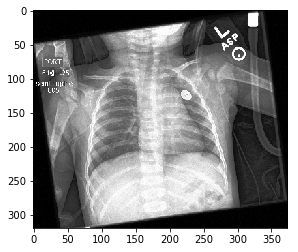

In [34]:
count1 = 0
count2 = 0
for i,pic in enumerate(train_df['Path']):
    img=Image.open(pic)
    if train_df['Pneumonia'][i] == 1:
        src = pic
        dst = './train/Pneumonia/' + pic
        shutil.copyfile(src, './train/Pneumonia/%d.jpg'%i)
        count1 += 1
    elif train_df['Pneumonia'][i] == -1:
        src = pic
        dst = './train/non_Pneumonia/' + pic
        shutil.copyfile(src, './train/non_Pneumonia/%d.jpg'%i)
        count2 += 1
print('Pneumonia',count1,'\t','non_Pneumonia',count2,'for training')
plt.imshow(img, cmap='gray')
plt.show()

In [35]:
# os.mkdir('test')
# os.mkdir('test/Pneumonia')
# os.mkdir('test/non_Pneumonia')

Pneumonia 8 	 non_Pneumonia 226 for testing


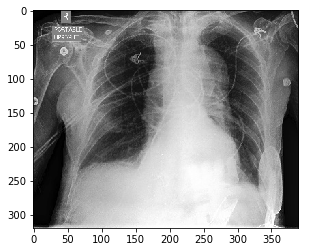

In [36]:
count1 = 0
count2 = 0
for i,pic in enumerate(test_df['Path']):
    img=Image.open(pic)
    
    if test_df['Pneumonia'][i] == 1:
        src = pic
        dst = './test/Pneumonia/' + pic
        shutil.copyfile(src, './test/Pneumonia/%d.jpg'%i)
        count1 += 1
    elif test_df['Pneumonia'][i] == 0:
        src = pic
        dst = './test/non_Pneumonia/' + pic
        shutil.copyfile(src, './test/non_Pneumonia/%d.jpg'%i)
        count2 += 1
print('Pneumonia',count1,'\t','non_Pneumonia',count2,'for testing')
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
#we have to do data augmentation for test data

In [27]:
K.clear_session()
nrow, ncol = 200,200
batch_size = 64
ntr = 1000
nts = 300

In [28]:
input_shape = (nrow,ncol,3)
base_model = applications.VGG16(weights='imagenet', include_top = False, input_shape = input_shape)
model = Sequential()
for layer in base_model.layers:
    model.add(layer)

In [29]:
for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [30]:
train_data_dir = './train'
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
train_generator = train_datagen.flow_from_directory(train_data_dir,target_size = (nrow,ncol),batch_size = batch_size,class_mode = 'binary')
test_data_dir = './test'
test_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
test_generator = test_datagen.flow_from_directory(test_data_dir,target_size = (nrow,ncol),batch_size = batch_size,class_mode = 'binary')

Found 24809 images belonging to 2 classes.
Found 234 images belonging to 2 classes.


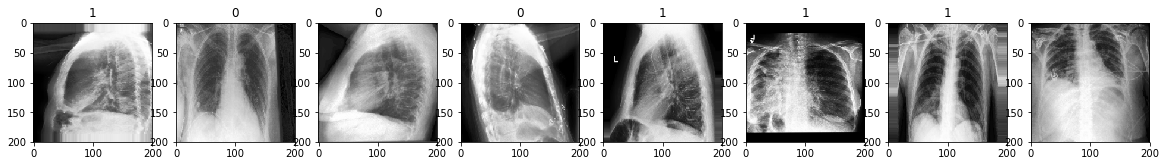

In [31]:
X,y = train_generator.next()
nplot = 8
plt.figure(figsize = (20,20))
for i in range(nplot):
    plt.title(int(y[i]))
    plt.subplot(1,nplot,i+1)
    plt.imshow(X[i], cmap='gray')

In [32]:
opt = Adam(lr=0.1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
steps_per_epoch = ntr // batch_size
validation_steps = nts// batch_size
nepochs = 5
hist = model.fit_generator(train_generator,steps_per_epoch = steps_per_epoch,epochs = nepochs,validation_data = test_generator,validation_steps = validation_steps)

Epoch 1/5
15/15 [==============================] - 17s 1s/step - loss: 0.7452 - acc: 0.6760 - val_loss: 0.3480 - val_acc: 0.9658
Epoch 2/5
15/15 [==============================] - 12s 783ms/step - loss: 0.5922 - acc: 0.7396 - val_loss: 0.3053 - val_acc: 0.9658
Epoch 3/5
15/15 [==============================] - 12s 827ms/step - loss: 0.6014 - acc: 0.7281 - val_loss: 0.3484 - val_acc: 0.9658
Epoch 4/5
15/15 [==============================] - 12s 800ms/step - loss: 0.5545 - acc: 0.7625 - val_loss: 0.3961 - val_acc: 0.9615
Epoch 5/5
15/15 [==============================] - 12s 791ms/step - loss: 0.5809 - acc: 0.7438 - val_loss: 0.3815 - val_acc: 0.9658


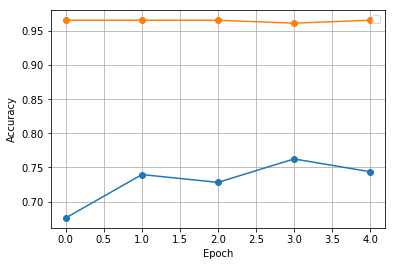

In [33]:
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.plot(hist.history['acc'], 'o-')
plt.plot(hist.history['val_acc'], 'o-')